# 任务1：PyTorch搭建LeNet模型进行MNIST分类

**任务要求：利用PyTorch框架搭建一个LeNet模型，并针对MNIST数据集进行训练和测试。**  
**数据：MNIST**

In [1]:
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
use_gpu = True if torch.cuda.is_available() else False
print('Use GPU:', use_gpu)

Use GPU: False


## 1. 数据集加载

利用torchvision的datasets加载MNSIT数据集

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])]
)

In [4]:
batch_size = 64
train_dataset = datasets.MNIST(root='./data/', train=True, transform=transform, download=True)
print(train_dataset)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_num = len(train_dataset)
print('train image num:', train_num)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )
train image num: 60000


In [5]:
test_dataset = datasets.MNIST(root='./data/', train=False, transform=transform, download=True)
print(test_dataset)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
test_num = len(test_dataset)
print('test image num:', test_num)

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )
test image num: 10000


## 2. LeNet模型构建

利用PyTorch构建LeNet模型类

In [6]:
class LeNet(nn.Module):
    ''' 请在下方编写LeNet模型的代码 '''
    import torch
    import torch.nn as nn
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1=nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5,stride=1),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc1=nn.Sequential(
            nn.Linear(in_features=4*4*16,out_features=120)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=120, out_features=84)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(in_features=84, out_features=10)
        )

    def forward(self, input):
        conv1_output=self.conv1(input)
        conv2_output = self.conv2(conv1_output)
        conv2_output=conv2_output.view(-1,4*4*16)
        fc1_output=self.fc1(conv2_output)
        fc2_output=self.fc2(fc1_output)
        fc3_output = self.fc3(fc2_output)
        return fc3_output

In [7]:
cnn = LeNet()
if use_gpu:
    cnn = cnn.cuda()
print(cnn)

LeNet(
  (conv1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
  )
  (fc2): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
  )
  (fc3): Sequential(
    (0): Linear(in_features=84, out_features=10, bias=True)
  )
)


## 3. 优化器和损失函数

定义优化器(SGD/Adam)和交叉熵损失函数

In [8]:
# 优化器
''' 请在下方编写优化器定义代码 '''
optimizer = optim.SGD(cnn.parameters(),lr=0.005,momentum = 0.9)
print(optimizer)

# 损失函数
''' 请在下方编写损失函数定义代码 '''
criterion = nn.CrossEntropyLoss() 
print(criterion)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.005
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
CrossEntropyLoss()


## 4. 模型训练和测试

模型训练函数(要求间隔记录输出损失函数及正确率)

In [9]:
# 训练CNN模型
def train(epoch):
    cnn.train()
    train_loss = 0
    correct = 0
    for batch_idx, (data, label) in enumerate(train_loader):
        if use_gpu:  # 使用GPU
            data, label = Variable(data).cuda(), Variable(label).cuda()
        
        ''' 请在下方编写计算损失函数、预测正确数、误差反向传播、梯度更新相关代码 '''
        
        output = cnn(data)
        optimizer.zero_grad()
        loss = criterion(output,label)
        loss.backward()
        optimizer.step()
        
        # 输出训练阶段loss信息
        train_loss += loss.item()
        train_loss_list.append(loss.item())
        pred = output.data.max(1)[1]
        correct += (pred.eq(label.data).cpu().sum()).item()
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{:05d}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), train_num,
                100 * batch_idx * len(data) / train_num, loss.item()))

    train_loss /= train_num
    accuracy = correct / train_num
    train_acc_list.append(accuracy)
    # 输出训练阶段loss信息
    print('Train Epoch: {}\tAverage loss: {:.4f}\tAccuracy: {}/{} ({:.2f}%)'.format(
        epoch, train_loss, correct, train_num, 100.0 * accuracy))

模型测试函数(要求间隔记录输出损失函数及正确率)

In [10]:
# 测试CNN模型
def test():
    cnn.eval()
    test_loss = 0
    correct = 0
    for data, label in test_loader:
        if use_gpu:  # 使用GPU
            data, label = Variable(data).cuda(), Variable(label).cuda()
            
        ''' 请在下方编写计算损失函数、预测正确数相关代码 '''
        data,label = Variable(data),Variable(label)
        output= cnn(data)
        loss = criterion(output,label)
        test_loss += loss.item()
        test_loss_list.append(loss.item())
        pred = output.data.max(1)[1]
        correct += (pred.eq(label.data).cpu().sum()).item()
    test_loss /= test_num
    accuracy = correct / test_num
    test_acc_list.append(accuracy)
    # 输出测试阶段loss信息
    print('Test Epoch: {}\tAverage loss: {:.4f}\tAccuracy: {}/{} ({:.2f}%)\n'.format(
        epoch, test_loss, correct, test_num, 100.0 * accuracy))

In [11]:
train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []
epoch_num = 10  # 可修改训练轮数

for epoch in range(1, epoch_num+1):
    # 每轮训练完测试
    train(epoch)
    test()

Train Epoch: 1 [00000/60000 (0%)]	Loss: 2.303026
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.229384
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.214227
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.060648
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.076596
Train Epoch: 1	Average loss: 0.0058	Accuracy: 53001/60000 (88.33%)
Test Epoch: 1	Average loss: 0.0019	Accuracy: 9643/10000 (96.43%)

Train Epoch: 2 [00000/60000 (0%)]	Loss: 0.141011


KeyboardInterrupt: 

## 5. 损失函数和正确率曲线

训练损失函数图 & 测试损失函数图 & 训练/测试正确率图

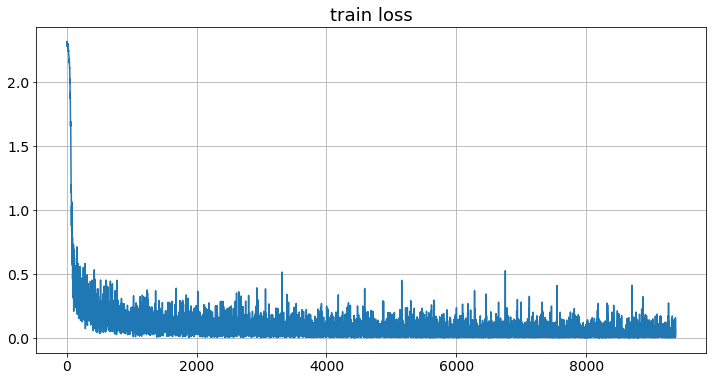

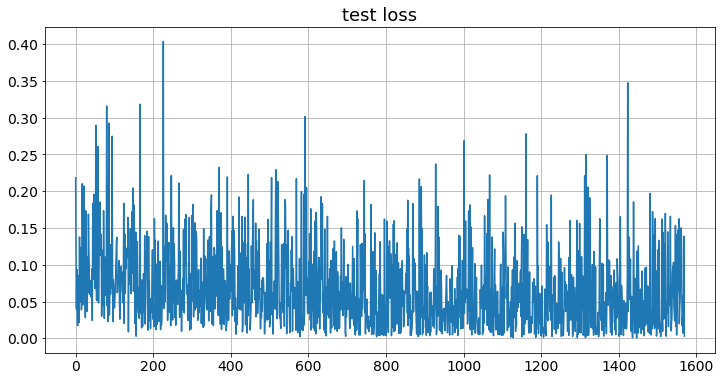

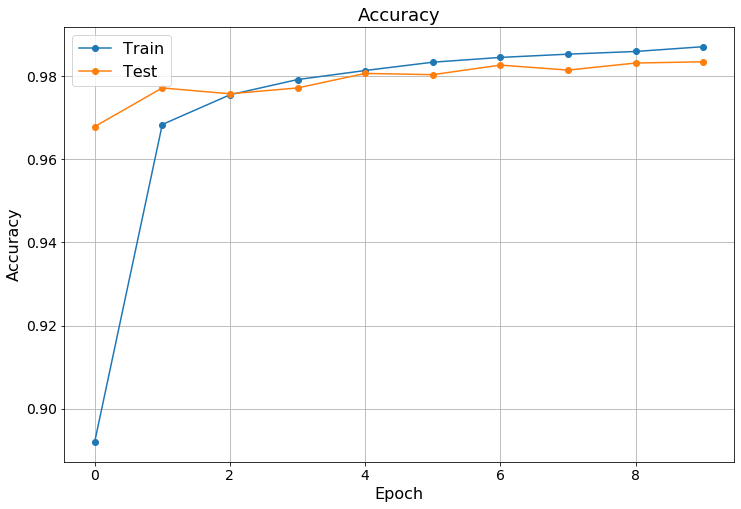

In [12]:
plt.figure(figsize=(12,6))
plt.plot(train_loss_list)
plt.title('train loss', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(test_loss_list)
plt.title('test loss', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.show()

plt.figure(figsize=(12,8))
plt.plot(train_acc_list, 'o-')
plt.plot(test_acc_list, 'o-')
plt.title('Accuracy', fontsize=18)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['Train', 'Test'], fontsize=16)
plt.grid()
plt.show()